<a href="https://colab.research.google.com/github/embarced/notebooks/blob/master/deep/transformers-pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLMS - OpenAI API

* https://platform.openai.com/docs/quickstart?context=python
* https://platform.openai.com/playground?mode=chat
* costs
  * https://openai.com/pricing
  * https://platform.openai.com/usage
* https://openai.com/blog/new-models-and-developer-products-announced-at-devday
* https://openai.com/enterprise-privacy
* https://platform.openai.com/docs/guides/embeddings/what-are-embeddings

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [4]:
if IN_COLAB:
    !pip install -q tiktoken
    !pip install -q  openai

# Tokenizer

* https://github.com/openai/tiktoken

In [6]:
import tiktoken

# To get the tokeniser corresponding to a specific model in the OpenAI API:
enc = tiktoken.encoding_for_model("gpt-4")
assert enc.decode(enc.encode("hello world")) == "hello world"
enc.encode("hello world!0")

[15339, 1917, 0, 15]

# OpenAI Client

In [9]:
# TODO: hier https://platform.openai.com/api-keys den eigenen Key erzeugen und eintragen
OPENAI_API_KEY = '...'

In [12]:
from openai import OpenAI

client = OpenAI(
  api_key=OPENAI_API_KEY
)
models = client.models.list()

In [13]:
set([model.owned_by for model in models])

{'openai', 'openai-dev', 'openai-internal', 'system'}

# Embeddings

* https://openai.com/blog/introducing-text-and-code-embeddings
* https://platform.openai.com/docs/guides/embeddings
* https://platform.openai.com/docs/quickstart?context=python&lang=Embeddings
* https://platform.openai.com/docs/guides/embeddings/what-are-embeddings


In [14]:
[model.id for model in models if model.owned_by == 'openai-internal']

['gpt-3.5-turbo-16k',
 'text-embedding-ada-002',
 'whisper-1',
 'text-davinci-003',
 'tts-1']

In [15]:
%%time

texts=[
    "Das Essen war toll und die Bedienung super!",
    "Uns hat das Restaurant sehr gefallen, sowohl die Speisen als auch der Service!",
    "Was für ein übles Erlebnis, meine Nudeln waren viel zu weich und es hat ewig gedauert, bis wir unser bedient wurden.",
    "Hunde mögen gern Knochen."
]

response = client.embeddings.create(
  model="text-embedding-ada-002",
  input=texts
)

CPU times: user 374 ms, sys: 681 ms, total: 1.06 s
Wall time: 1.06 s


In [17]:
import numpy as np

embeddings = np.array([embedding.embedding for embedding in response.data])
embeddings.shape

(4, 1536)

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim_matrix = cosine_similarity(embeddings)
cos_sim_matrix

array([[1.        , 0.9293744 , 0.86139925, 0.77319146],
       [0.9293744 , 1.        , 0.84499725, 0.76927185],
       [0.86139925, 0.84499725, 1.        , 0.76339409],
       [0.77319146, 0.76927185, 0.76339409, 1.        ]])

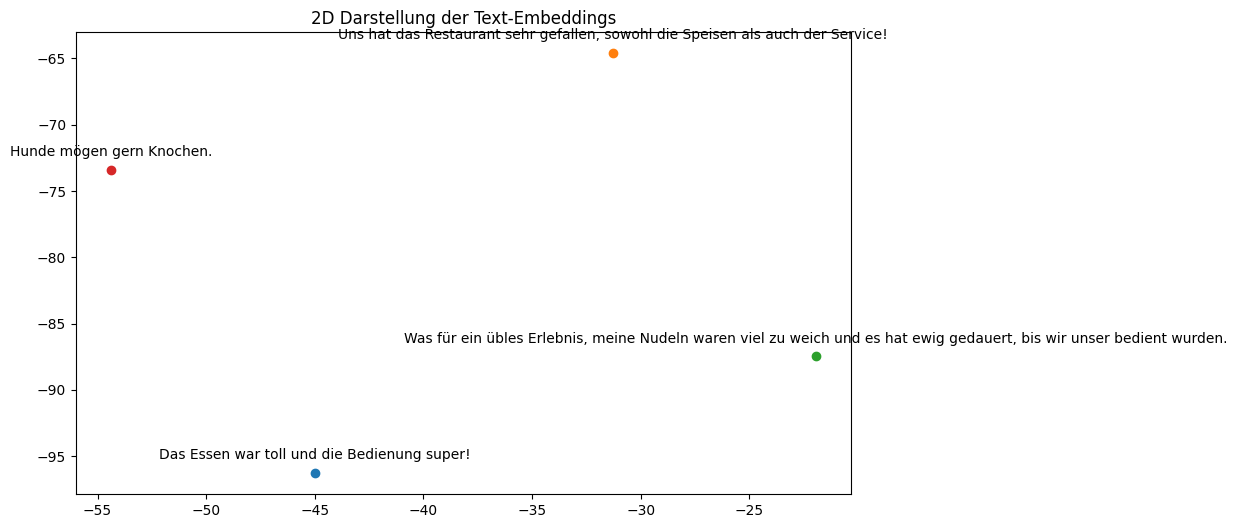

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0, perplexity=3)
reduced_embeddings = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
for i, label in enumerate(texts):
    x, y = reduced_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')
plt.title('2D Darstellung der Text-Embeddings')
plt.show();

# Completion

In [22]:
[model.id for model in models if model.owned_by == 'openai']

['gpt-3.5-turbo-16k-0613',
 'babbage',
 'text-babbage-001',
 'code-davinci-edit-001',
 'curie-instruct-beta',
 'gpt-3.5-turbo',
 'davinci-instruct-beta',
 'gpt-4',
 'text-davinci-001',
 'text-davinci-002',
 'text-davinci-edit-001',
 'ada',
 'gpt-3.5-turbo-0613',
 'text-ada-001',
 'gpt-3.5-turbo-0301',
 'gpt-4-0613',
 'text-curie-001',
 'curie',
 'gpt-4-0314',
 'davinci']

In [23]:
%%time

# https://platform.openai.com/docs/quickstart/step-3-sending-your-first-api-request
completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a poetic assistant, skilled in explaining complex programming concepts with creative flair."},
    {"role": "user", "content": "Compose a poem that explains the concept of recursion in programming."}
  ]
)

CPU times: user 14.5 ms, sys: 0 ns, total: 14.5 ms
Wall time: 36.2 s


In [24]:
completion.choices[0].message.content

"In the realm of code where wonders reside,\nThere dwells a concept, both fascinating and wide.\nA dance of function, enchanting to see,\nLet me unveil the magic of recursion, with glee.\n\nImagine a puzzle, oh, so grand,\nWith pieces entwined, a puzzle that demands,\nTo solve its riddles, you must persist,\nAnd in recursion's embrace, you shall enlist.\n\nWith each deft move, an elegant play,\nA function calls itself, it doesn't stray,\nDividing the puzzle into parts untold,\nUntil a base case emerges, bold and behold.\n\nLike a fractal painting upon the screen,\nRecursive beauty, a celestial gleam,\nUnfolding layers with patterns intricate,\nA cascade of logic, both delicate and great.\n\nBut hark! Beware the infinite abyss,\nFor recursion's allure holds a perilous twist.\nWithout a stopping condition, it knows no end,\nA boundless loop, a coder's descent.\n\nAlas, with wisdom, we set our rules,\nOn the treacherous path, we must not lose.\nFor recursion, dear friend, is a double-edge

In [25]:
# experimental models
[model.id for model in models if model.owned_by == 'system']

['gpt-4-1106-preview',
 'gpt-3.5-turbo-1106',
 'gpt-4-vision-preview',
 'babbage-002',
 'davinci-002',
 'tts-1-hd',
 'tts-1-hd-1106',
 'gpt-3.5-turbo-instruct-0914',
 'canary-whisper',
 'gpt-3.5-turbo-instruct',
 'canary-tts',
 'dall-e-2',
 'tts-1-1106',
 'dall-e-3']

# Function Calling

* https://platform.openai.com/docs/guides/function-calling
* https://cookbook.openai.com/examples/how_to_call_functions_with_chat_models

In [30]:
model="gpt-3.5-turbo-1106"
# model="gpt-4-1106-preview"

tools = [
    {
        "type": "function",
        "function": {
            "name": "list_employee_ids",
            "description": "Enumerate the integer id of all employees",
            "parameters": {
                "type": "object",
                "properties": {
                }
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "get_employee_detail",
            # "description": "Gets the employee's details including salary and job title based on their id",
            "description": "Gets the employee's details",
            "parameters": {
                "type": "object",
                "properties": {
                    "id": {
                        "type": "integer",
                        "description": "The id of the employee like returned by list_employee_ids",
                    }
                },
                "required": ["id"],
            },
        },
    }

]

def user_input(messages, content = None):
  if content:
    message = {"role": "user", "content": content}
    messages.append(message)
  response = client.chat.completions.create(
      model=model,
      messages=messages,
      tools=tools,
  )
  response_message = response.choices[0].message
  messages.append(response_message)
  return response_message

In [33]:
messages = []
response_message = user_input(messages, "Was ist das durschschnittliche Gehalt aller Mitarbeiter?")
messages

[{'role': 'user',
  'content': 'Was ist das durschschnittliche Gehalt aller Mitarbeiter?'},
 ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_0m9JC0frw6yGT2USn7Gt32iL', function=Function(arguments='{}', name='list_employee_ids'), type='function')])]

In [34]:
tool_calls = response_message.tool_calls
assert tool_calls

In [28]:
employees = [
    {
        "name": "Oliver Zeigermann",
        "position": "CTO",
        "salary": 200_000
    },
    {
        "name": "Chi Nhan Nguyen",
        "position": "CEO",
        "salary": 250_000
    }
]

def get_employee_detail(id):
  print(id)
  if int(id) <= len(employees):
    return employees[id -1]
  return None

def list_employee_ids():
  return list(iter(range(1, len(employees) + 1)))

In [29]:
import json

def execute_tool_call(tool_call):
    function_name = tool_call.function.name
    function_to_call = globals()[function_name]
    function_args = json.loads(tool_call.function.arguments)

    function_response = function_to_call(**function_args)
    print(f"Calling {function_name} with {function_args}, getting {function_response}")
    return {
            "tool_call_id": tool_call.id,
            "role": "tool",
            "name": function_name,
            "content": json.dumps(function_response),
    }

def execute_tool_calls(messages, tool_calls):
  for tool_call in tool_calls:
    message = execute_tool_call(tool_call)
    messages.append(message)

In [35]:
execute_tool_calls(messages, tool_calls)
messages

Calling list_employee_ids with {}, getting [1, 2]


[{'role': 'user',
  'content': 'Was ist das durschschnittliche Gehalt aller Mitarbeiter?'},
 ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_0m9JC0frw6yGT2USn7Gt32iL', function=Function(arguments='{}', name='list_employee_ids'), type='function')]),
 {'tool_call_id': 'call_0m9JC0frw6yGT2USn7Gt32iL',
  'role': 'tool',
  'name': 'list_employee_ids',
  'content': '[1, 2]'}]

In [36]:
response_message = user_input(messages)
response_message

ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_vTcQe9pfmldztUdjzDuzF7DD', function=Function(arguments='{"id": 1}', name='get_employee_detail'), type='function'), ChatCompletionMessageToolCall(id='call_RRsD5LL7zYkWSuHHqJHeDc2y', function=Function(arguments='{"id": 2}', name='get_employee_detail'), type='function')])

In [37]:
tool_calls = response_message.tool_calls
assert tool_calls
tool_calls

[ChatCompletionMessageToolCall(id='call_vTcQe9pfmldztUdjzDuzF7DD', function=Function(arguments='{"id": 1}', name='get_employee_detail'), type='function'),
 ChatCompletionMessageToolCall(id='call_RRsD5LL7zYkWSuHHqJHeDc2y', function=Function(arguments='{"id": 2}', name='get_employee_detail'), type='function')]

In [38]:
execute_tool_calls(messages, tool_calls)
messages

1
Calling get_employee_detail with {'id': 1}, getting {'name': 'Oliver Zeigermann', 'position': 'CTO', 'salary': 200000}
2
Calling get_employee_detail with {'id': 2}, getting {'name': 'Chi Nhan Nguyen', 'position': 'CEO', 'salary': 250000}


[{'role': 'user',
  'content': 'Was ist das durschschnittliche Gehalt aller Mitarbeiter?'},
 ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_0m9JC0frw6yGT2USn7Gt32iL', function=Function(arguments='{}', name='list_employee_ids'), type='function')]),
 {'tool_call_id': 'call_0m9JC0frw6yGT2USn7Gt32iL',
  'role': 'tool',
  'name': 'list_employee_ids',
  'content': '[1, 2]'},
 ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_vTcQe9pfmldztUdjzDuzF7DD', function=Function(arguments='{"id": 1}', name='get_employee_detail'), type='function'), ChatCompletionMessageToolCall(id='call_RRsD5LL7zYkWSuHHqJHeDc2y', function=Function(arguments='{"id": 2}', name='get_employee_detail'), type='function')]),
 {'tool_call_id': 'call_vTcQe9pfmldztUdjzDuzF7DD',
  'role': 'tool',
  'name': 'get_employee_detail',
  'content': '{"name": "Oliver Zeigermann", "positi

In [39]:
response_message = user_input(messages)
response_message

ChatCompletionMessage(content='Das durchschnittliche Gehalt aller Mitarbeiter beträgt 225.000 €.', role='assistant', function_call=None, tool_calls=None)